In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import math

from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.patches import Rectangle
from pyvis.network import Network

### One function for each step in the pipeline

In [15]:
def get_ocr_data(json_file, min_chars = 2):
    with open(json_file) as fp:
        data = json.loads(fp.read())
    
    nodes = []

    for b in data['Blocks']:
        if b['BlockType'] == 'LINE' and len(b['Text']) >= min_chars:
            node = {'text': b['Text'], 
                    'left': b['Geometry']['BoundingBox']['Left'], 
                    'top': b['Geometry']['BoundingBox']['Top'],
                    'right': b['Geometry']['BoundingBox']['Left'] + b['Geometry']['BoundingBox']['Width'],
                    'bottom': b['Geometry']['BoundingBox']['Top'] + b['Geometry']['BoundingBox']['Height']}

            nodes.append(node)
    
    return pd.DataFrame(nodes)

In [3]:
def open_image(filename, threshold_value = 200):
    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    threshold = 1 - (threshold / 255.)
    
    return threshold

In [4]:
def set_bounding_boxes_in_pixels(df, img):
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    for i, row in df.iterrows():
         
        df.at[i, 'left']   = int(round(row['left'] * img_width))
        df.at[i, 'right']  = int(round(row['right'] * img_width))
        df.at[i, 'top']    = int(round(row['top'] * img_height))
        df.at[i, 'bottom'] = int(round(row['bottom'] * img_height))
        
    df['left']   = df['left'].astype(int)
    df['right']  = df['right'].astype(int)
    df['top']    = df['top'].astype(int)
    df['bottom'] = df['bottom'].astype(int)
    
    return df

In [5]:
def get_font_size(df):
    
    df['font_size'] = df.bottom - df.top
    
    df['font_size'] = (df['font_size'] - df['font_size'].mean()) / (df['font_size'].std() + 1e-6)
    
    df['font_size'] = (df['font_size'].apply(lambda x: round(x)) + 10).astype(int)
    
    return df

In [6]:
def close_shape_gaps4(image, ocr,
                      dist_threshold_percent = 2, 
                      activation_lower_th = 40, 
                      activation_upper_th = 70):

    img = image.copy()

    img = (1-img) * 10

    kernel = np.ones((3, 3), np.uint8)
    kernel[1,1] = 10
    
    dst = cv2.filter2D(img,-1,kernel).astype(int)
    
    points_thr = np.where((dst > activation_lower_th) & (dst < activation_upper_th))

    points = []
    for p_i in range(len(points_thr[0])): 
        points.append([points_thr[0][p_i], points_thr[1][p_i]])

    points = np.stack(points, axis=0)
    
    dist_matrix = euclidean_distances(points)
    
    mean_bb_height = (ocr.bottom - ocr.top).mean()
    
    dist_threshold = int((mean_bb_height * dist_threshold_percent)/100)

    below_th = np.where(dist_matrix < dist_threshold)
    
    img_out = image.copy()

    for i in range(len(below_th[0])):

        p1 = points[below_th[0][i]]
        p2 = points[below_th[1][i]]

        cv2.line(img_out, [p1[1],p1[0]], [p2[1],p2[0]],  (1, 1, 1), thickness=1)
        
    return img_out

In [7]:
def stamp_bounding_boxes_on_image(df, img):
    
    img_out = img.copy()

    for i, row in df.iterrows():

        img_out[ row['top']:row['bottom'], row['left']:row['right']] = 1
    
    return img_out

In [8]:
def get_filled_shapes(img):
    
    contours, tree = cv2.findContours(cv2.convertScaleAbs(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_out = np.zeros_like(img)

    for i, contour in enumerate(contours):
        cv2.drawContours(img_out, [contour], 0, (1, 1, 1), thickness=cv2.FILLED)
        
    return img_out

In [9]:
def get_masks(img, max_iter=10):
    

    kernel = np.ones((3, 3), np.uint8)

    img_eroded = [img.copy()]
    contours_iter = []

    for i in range(max_iter):
        contours, tree = cv2.findContours(cv2.convertScaleAbs(img_eroded[-1]), 
                                          cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours_iter.append(contours)
        img_eroded.append(cv2.erode(img_eroded[-1], kernel, iterations = 1))
    
    min_contours = len(contours_iter[-1])
    min_contours_iteration = len(contours_iter)-1

    for i in range(len(contours_iter)-1, -1, -1):
        if len(contours_iter[i]) > min_contours:
            min_contours_iteration = i+1
            break
            
            
    nodes_mask = img_eroded[min_contours_iteration]
    
    nodes_mask_dilated = cv2.dilate(nodes_mask, kernel, iterations=min_contours_iteration+1)
    edges_mask = np.maximum((img_eroded[0] - nodes_mask_dilated), 0)


    return nodes_mask, edges_mask

In [10]:
def get_edges(edges_mask):
    
    final_edges = []

    contours, tree = cv2.findContours(cv2.convertScaleAbs(edges_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:

        countour_points = contour[:,0,:]

        x_min = np.min(countour_points[:,0])
        x_max = np.max(countour_points[:,0])
        y_min = np.min(countour_points[:,1])
        y_max = np.max(countour_points[:,1])

        candidates = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])

        minimum_distances_to_candidates = np.min(euclidean_distances(candidates, countour_points), axis=1)

        final_endpoints = candidates[np.argsort(minimum_distances_to_candidates)[:4], :]
        
        
        if np.linalg.norm(final_endpoints[0] - final_endpoints[1]) * 2 < np.linalg.norm(final_endpoints[0] - final_endpoints[2]):
    
            final_endpoints = np.array([final_endpoints[0], final_endpoints[2]])

        else:
            final_endpoints = final_endpoints[0:2]

        final_edges.append(final_endpoints)


    return np.stack(final_edges)

In [11]:
def get_connections(edges, nodes_mask, dist_threshold_percentage = 2):
    
    connections = []
    
    dist_threshold_in_pixels = int((dist_threshold_percentage / 100) * nodes_mask.shape[0])
    
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for edge in edges:

        connection = [None, None]

        for i_endpoint, endpoint in enumerate(edge):

            endpoint = np.expand_dims(endpoint, axis=0)

            min_dist_to_node = 9e3
            min_dist_node_n = -1

            for i_node, node in enumerate(nodes_contours):

                node = node[:,0,:]

                min_dist = np.min(euclidean_distances(node, endpoint).squeeze())

                if min_dist < min_dist_to_node:
                    min_dist_to_node = min_dist
                    min_dist_node_n = i_node

            if min_dist_to_node < dist_threshold_in_pixels:

                connection[i_endpoint] = min_dist_node_n

        if connection[0] is not None and connection[1] is not None and connection[0] != connection[1]:
            connections.append(connection) 
    
    return pd.DataFrame(connections, columns=['node a', 'node b'])

In [12]:
def get_nodes(ocr, nodes_mask, threshold_iou = 0.8):
    
    df = ocr.copy()
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    for i, row in df.iterrows():

        area = (row['right'] - row['left']) * (row['bottom'] - row['top'])

        max_iou = 0
        max_iou_i_node = -1
        

        for i_node, contour in enumerate(nodes_contours):

            empty_img = np.zeros_like(nodes_mask)

            cv2.drawContours(empty_img, [contour], 0, (1, 1, 1), thickness=-1)

            intersection = empty_img[row['top']:row['bottom'], row['left']:row['right']].sum()

            iou = intersection / area

            if iou > max_iou:
                max_iou = iou
                max_iou_i_node = i_node

        if max_iou > threshold_iou:

            df.at[i, 'node_id'] = max_iou_i_node
    
    return df

# Real data

In [13]:
images = ['small_mindmap3.jpg', 
          'small_mindmap3_implicit_nodes.jpg', 
          '3.7.1 Inheritance_1.jpg', 
          '3.7.1 Inheritance_2.jpg',
          'erythrocytes L1 .jpg',
          'erythrocytes L1_2.jpg']

ocrs = ['mindmap3', 
        'mindmap3_implicit_nodes', 
        '3.7.1 Inheritance_1', 
        '3.7.1 Inheritance_2', 
        'erythrocytes L1', 
        'erythrocytes L1_2']

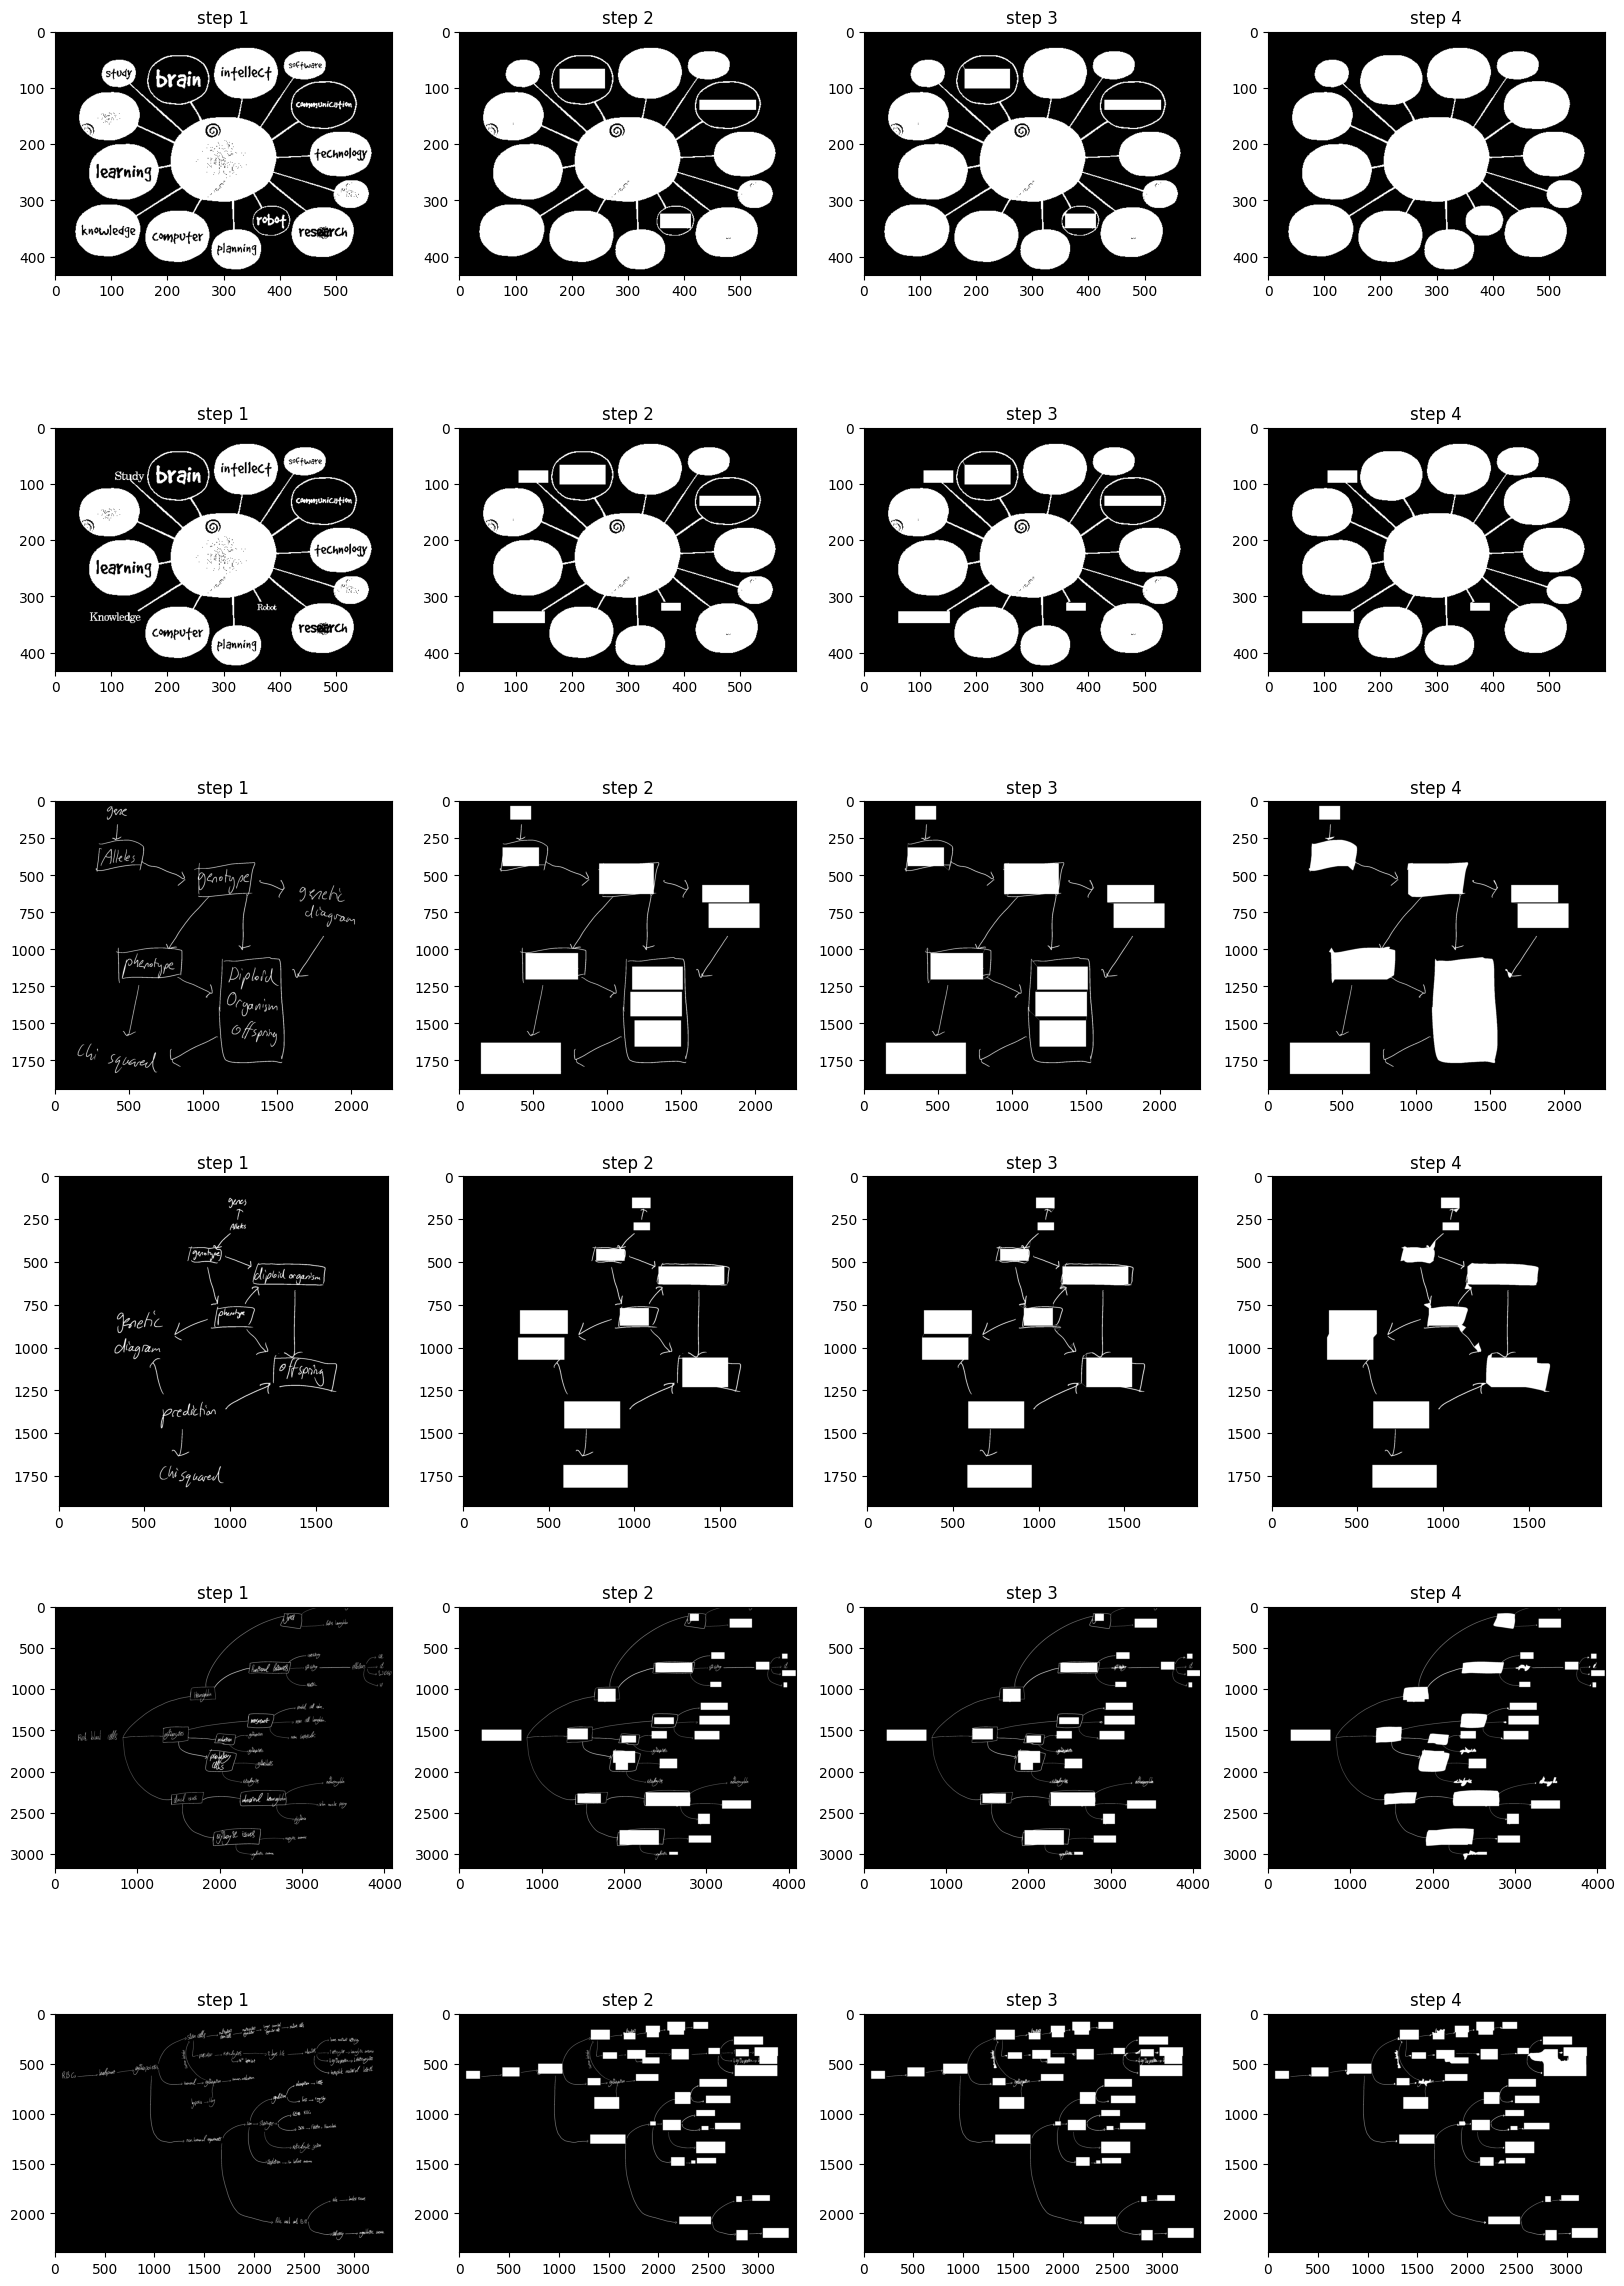

In [16]:
n_images = len(images)

proc_images = []

for index in range(n_images):

    ocr = get_ocr_data(f'../textract_outputs/{ocrs[index]}/analyzeDocResponse.json', min_chars = 2)

    image = []

    image.append(open_image(f'../graphs/{images[index]}', threshold_value=200))
    ocr = set_bounding_boxes_in_pixels(ocr, image[-1])


    image.append(stamp_bounding_boxes_on_image(ocr, image[-1]))
    image.append(close_shape_gaps4(image[-1], ocr, dist_threshold_percent = 35))
    image.append(get_filled_shapes(image[-1]))
    
    proc_images.append(image)


n_steps = len(image)


fig, ax = plt.subplots(n_images, n_steps, figsize=(5*n_steps, 5*n_images))

for i in range(n_images):
    for j in range(n_steps):
        ax[i, j].imshow(proc_images[i][j], cmap='gray')
        ax[i, j].set_title(f'step {j+1}')
    
plt.show()

## Font size

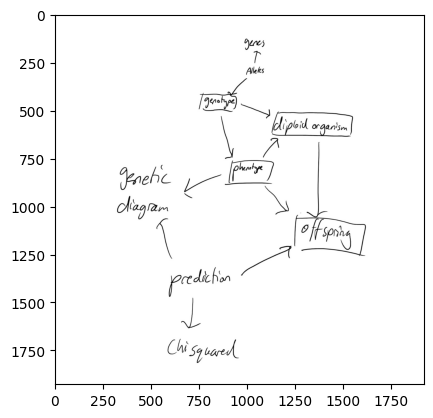

,text,left,top,right,bottom,font_size
0,genes,985,126,1093,188,9
1,Alleles,994,271,1090,317,8
2,genotype,776,426,942,495,9
3,diploid organism,1139,528,1523,633,10
4,genetic,332,784,611,922,11
5,phenotype,914,771,1083,874,10
6,diagram,321,943,591,1073,10
7,offspring,1278,1060,1545,1233,11
8,prediction,590,1316,916,1474,11
9,Chi squared,585,1687,960,1820,11


In [23]:
index = 3

ocr = get_ocr_data(f'../textract_outputs/{ocrs[index]}/analyzeDocResponse.json', min_chars = 2)

image = open_image(f'../graphs/{images[index]}', threshold_value=200)
ocr = set_bounding_boxes_in_pixels(ocr, image)
ocr = get_font_size(ocr)


img = cv2.imread(f'../graphs/{images[index]}')

plt.imshow(img)
plt.show()

ocr